In [3]:
# Cell 1: Imports and Data Loading
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap

# Set plot style
sns.set_theme(style="whitegrid")

# Load the encoded data prepared for modeling
df = pd.read_csv('../data/processed/final_modeling_data.csv')

# Separate Features (X) and Target (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

# Split the data
# We split BEFORE oversampling to prevent data leakage (common error to avoid!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data (Required for Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Split Complete.")
print(f"Training Shape: {X_train.shape}, Test Shape: {X_test.shape}")
print(f"Stroke cases in Train: {sum(y_train)}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Data Split Complete.
Training Shape: (4088, 25), Test Shape: (1022, 25)
Stroke cases in Train: 199


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Cell 2: Handling Imbalance (SMOTE)
# Constraint Checklist: "Address class imbalance."
# We apply SMOTE only to the training set to synthesize minority class samples.

print("Target distribution before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\nTarget distribution after SMOTE:")
print(y_train_smote.value_counts())

Target distribution before SMOTE:
stroke
0    3889
1     199
Name: count, dtype: int64

Target distribution after SMOTE:
stroke
0    3889
1    3889
Name: count, dtype: int64


In [5]:
# Cell 3: Model 1 - XGBoost (Ensemble Method) with Hyperparameter Tuning
# Constraint Checklist: "Compare advanced algorithms" + "Hyperparameter tuning"

# Define the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')

# Define Hyperparameters for Grid Search
# limiting depth and estimators to keep training time reasonable while proving the concept
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8]
}

# Grid Search with Cross Validation (using F1 score as the metric because accuracy is misleading here)
grid_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='f1', verbose=1)
grid_xgb.fit(X_train_smote, y_train_smote)

# Best Model
best_xgb = grid_xgb.best_estimator_
print(f"Best XGBoost Params: {grid_xgb.best_params_}")

# Predictions
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

print("\n--- XGBoost Evaluation ---")
print(classification_report(y_test, y_pred_xgb))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

--- XGBoost Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       972
           1       0.20      0.10      0.13        50

    accuracy                           0.94      1022
   macro avg       0.58      0.54      0.55      1022
weighted avg       0.92      0.94      0.93      1022

AUC-ROC Score: 0.7907


In [6]:
# Cell 4: Model 2 - Neural Network (MLPClassifier)
# Constraint Checklist: "Compare... Neural Networks"

# We use Scikit-Learn's MLPClassifier.
# Note: MLP requires careful scaling (which we did in Cell 1).

mlp = MLPClassifier(max_iter=500, random_state=42, early_stopping=True)

# Tuning Hidden Layers and Activation
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.05] # Regularization term
}

grid_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=3, scoring='f1', verbose=1)
grid_mlp.fit(X_train_smote, y_train_smote)

best_mlp = grid_mlp.best_estimator_
print(f"Best MLP Params: {grid_mlp.best_params_}")

# Predictions
y_pred_mlp = best_mlp.predict(X_test_scaled)
y_prob_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]

print("\n--- Neural Network Evaluation ---")
print(classification_report(y_test, y_pred_mlp))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_mlp):.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}

--- Neural Network Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.12      0.16      0.13        50

    accuracy                           0.90      1022
   macro avg       0.54      0.55      0.54      1022
weighted avg       0.91      0.90      0.91      1022

AUC-ROC Score: 0.7340


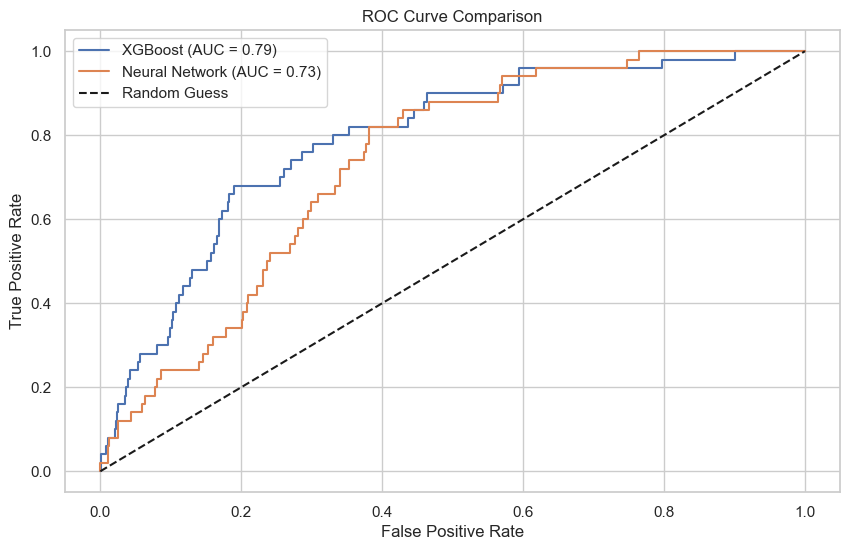

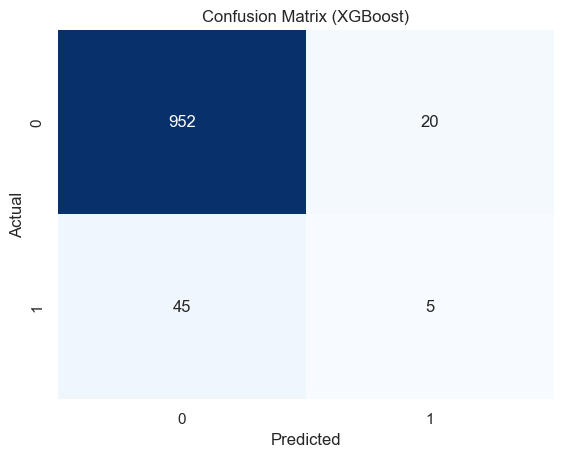

Best model (XGBoost) saved to ../dashboard/model.pkl


In [7]:
# Cell 5: Visual Comparison & Error Analysis
# Constraint Checklist: "Visualize results (ROC)" + "Analyze Errors"

# 1. ROC Curve Comparison
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xgb):.2f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'Neural Network (AUC = {roc_auc_score(y_test, y_prob_mlp):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# 2. Confusion Matrix for the Best Model (usually XGBoost performs better on tabular data)
# We focus on False Negatives (Predicting No Stroke when there IS a Stroke) - High Business Risk
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. Save the best model logic for later use in Dashboard
import pickle
with open('../dashboard/model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)
    
print("Best model (XGBoost) saved to ../dashboard/model.pkl")

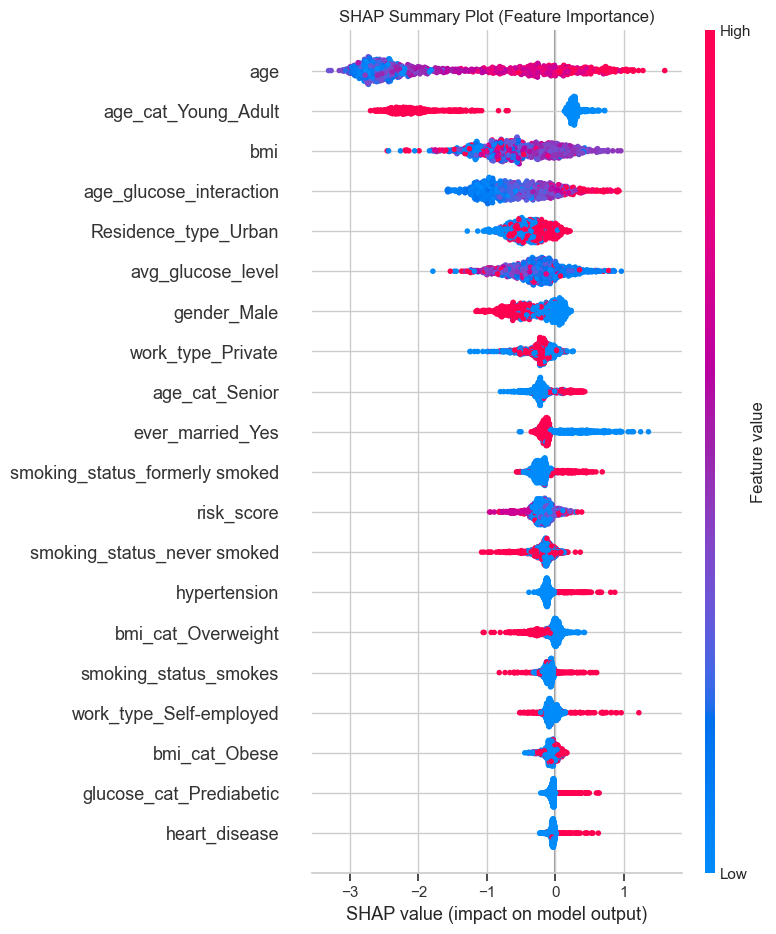

In [8]:
# Cell 6: Model Interpretability (SHAP)
# Constraint Checklist: "Explainability using SHAP/LIME"

# SHAP works best with Tree-based models like XGBoost
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_scaled)

plt.title('SHAP Summary Plot (Feature Importance)')
# Summary plot shows which features push the prediction towards "Stroke" (Right) or "No Stroke" (Left)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

In [9]:
# Cell 7: Save Model AND Scaler for Dashboard
import pickle
import os

# 1. Ensure the folder exists
os.makedirs('../dashboard', exist_ok=True)

# 2. Save the Best Model (XGBoost)
with open('../dashboard/model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)
print("Model saved to ../dashboard/model.pkl")

# 3. Save the Scaler (CRITICAL for dashboard to work)
with open('../dashboard/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved to ../dashboard/scaler.pkl")

Model saved to ../dashboard/model.pkl
Scaler saved to ../dashboard/scaler.pkl
